##  Individual - Sketching - Suhaib Basir

In [56]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nbformat
from tqdm import tqdm
import time
import sys
import mmh3  # mmh3 is a Python wrapper for MurmurHash (a set of good general purpose hash functions)

nb = nbformat.read("Lab3_sketching_final.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 584


## 1. Familiarization and discretization task (Left in for completeness)

In [33]:
# Specify the columns you want to read as strings
string_columns = ['sTos', 'dTos']

# Specify the columns you want to read as strings
data10 = "dataset_lab3/dataset_10/capture20110818.binetflow"

df10 = pd.read_csv(data10, dtype={col: str for col in string_columns})

infected_hosts = ['147.32.84.165', '147.32.84.191', '147.32.84.192', '147.32.84.193','147.32.84.204', '147.32.84.205', '147.32.84.206','147.32.84.207', '147.32.84.208', '147.32.84.209']

In [34]:
def discretise_netflow(df1):
    df1['bytes_per_second'] = df1['SrcBytes'] / (df1['Dur'] + 1e-10)

    # Discretize numeric columns using percentiles
    for column in df1.columns:
        if df1[column].dtype == np.float64 or df1[column].dtype == np.int64:
            df1[column] = pd.qcut(df1[column], q=10, labels=False, duplicates='drop')

    return df1

df10 = discretise_netflow(df10)

### 1a. Plot visualizations - Select and visualize two features for modeling the behavior of the infected host.

In [35]:
# Filter columns that are either integers or floats
numeric_cols_infected = df10[df10['SrcAddr'] == infected_hosts[1]].select_dtypes(include=['int', 'float'])
numeric_cols_other = df10[df10['SrcAddr'] != infected_hosts[1]].select_dtypes(include=['int', 'float'])

# Calculate the average and standard deviation for df_srcaddr_147
avg_values_infected = numeric_cols_infected.mean()
std_values_infected = numeric_cols_infected.std()
print(f'calculated for infected')

# Calculate the average and standard deviation for df_srcaddr_other
avg_values_other = numeric_cols_other.mean()
std_values_other = numeric_cols_other.std()
print('calculated for other')

# Print the average and standard deviation side by side
print(f"{'Column':<15} {'Average (infected)':<15} {'Std Deviation (infected)':<20} {'Average (Other)':<15} {'Std Deviation (Other)':<20}")
print("-" * 90)
for column in avg_values_infected.index:
    avg_147 = avg_values_infected[column]
    std_147 = std_values_infected[column]
    avg_other = avg_values_other[column]
    std_other = std_values_other[column]
    print(f"{column:<15} {avg_147:<15.2f} {std_147:<20.2f} {avg_other:<15.2f} {std_other:<20.2f}")

calculated for infected
calculated for other
Column          Average (infected) Std Deviation (infected) Average (Other) Std Deviation (Other)
------------------------------------------------------------------------------------------
Dur             0.89            2.68                 4.53            2.86                
TotPkts         0.16            0.72                 0.94            1.40                
TotBytes        5.24            0.75                 3.59            2.62                
SrcBytes        6.19            0.63                 3.66            2.53                
bytes_per_second 8.21            2.37                 4.47            2.86                


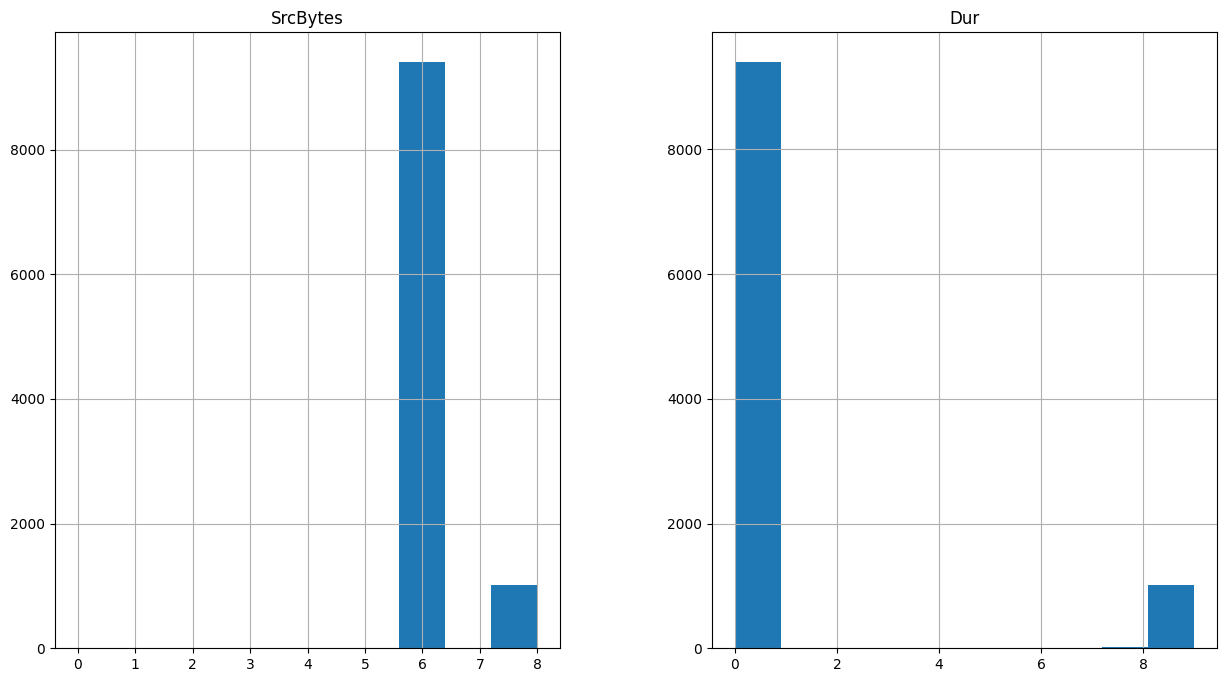

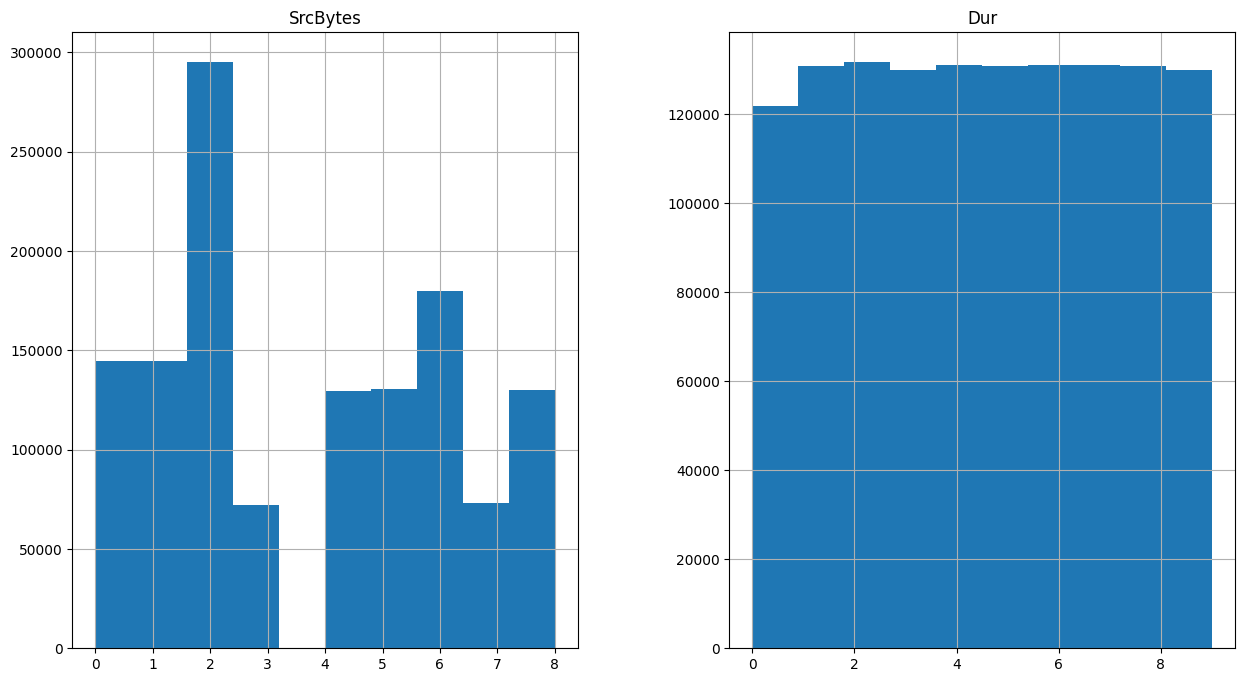

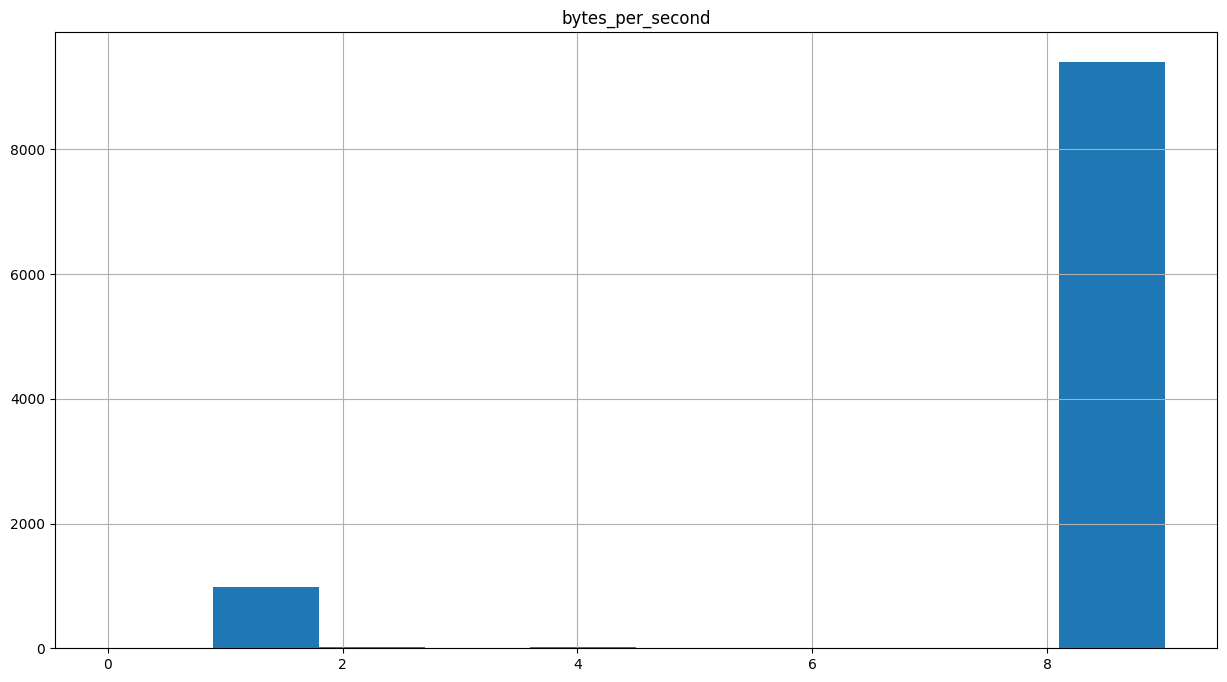

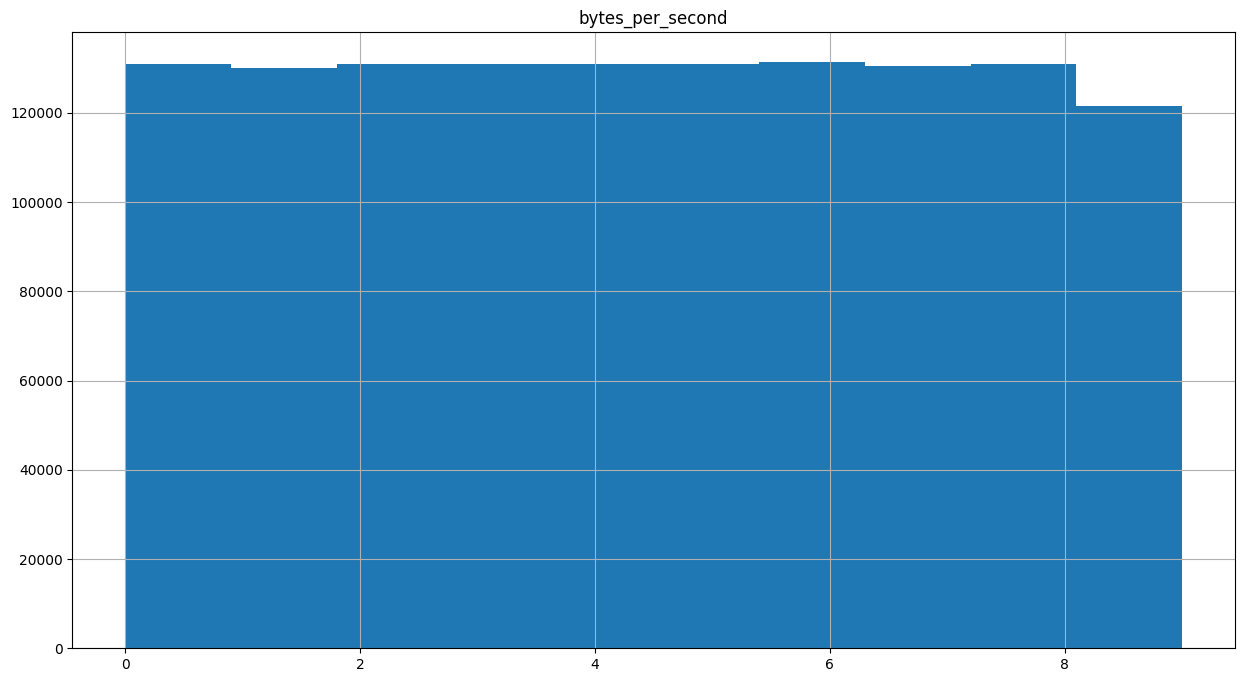

In [36]:
numeric_cols_infected[['SrcBytes', 'Dur']].hist(bins=10, figsize=(15, 8))
plt.show()

numeric_cols_other[['SrcBytes', 'Dur']].hist(bins=10, figsize=(15, 8))
plt.show()

numeric_cols_infected[['bytes_per_second']].hist(bins=10, figsize=(15, 8))
numeric_cols_other[['bytes_per_second']].hist(bins=10, figsize=(15, 8))
plt.show()


In [37]:
print(df10['bytes_per_second'].head())

0    2
1    1
2    0
3    2
4    2
Name: bytes_per_second, dtype: int64


## Sketching task

In [39]:
import random
import numpy as np

def generate_hash_functions(k, p, m):

    # as defined in the lecture slides
    def hash_function(a, b, p, m):
        return lambda x: ((a*x + b) % p) % m

    hash_functions = []
    for _ in range(k):
        a = random.randint(1, p-1)
        b = random.randint(0, p-1)
        hash_functions.append(hash_function(a, b, p, m))
        
    return hash_functions

class CountMinSketch2:
    def __init__(self, depth, width):
        self.depth = depth
        self.width = width
        self.table = np.zeros((depth, width))
        p = 2**31 - 1
        self.hash_functions = generate_hash_functions(depth, p, width)

    def add(self, x):
        x = int(''.join(map(str, x)))  # convert the tuple to a unique integer
        for i in range(self.depth):
            index = self.hash_functions[i](x)
            self.table[i, index] += 1

    def estimate(self, x):
        x = int(''.join(map(str, x)))  # convert the tuple to a unique integer
        min_est = float('inf')
        for i in range(self.depth):
            index = self.hash_functions[i](x)
            min_est = min(min_est, self.table[i, index])
        return min_est


In [40]:
# Create 3-grams 
three_grams = [tuple(df10.iloc[i:i+3]['bytes_per_second'].tolist()) for i in range(len(df10)-2)]

In [41]:
print(three_grams[:5])

[(2, 1, 0), (1, 0, 2), (0, 2, 2), (2, 2, 2), (2, 2, 2)]


In [46]:
# Initialize Count-Min sketch
depth, width = 100, 90  
depth2, width2 = 100, 1000  
depth3, width3 = 5, 45 
depth4, width4 = 5, 16000 
depth5, width5 = 25, 25

cms = CountMinSketch2(depth, width)
cms2 = CountMinSketch2(depth2, width2)
cms3 = CountMinSketch2(depth3, width3)
cms4 = CountMinSketch2(depth4, width4)
cms5 = CountMinSketch2(depth5, width5)

In [47]:
def countMinSketchRun(cms, tg):
    start_time = time.time()
    # Add 3-grams to sketch
    for tg in three_grams:
        cms.add((tg))  # convert 3-gram to string before hashing

    estimates = []
    # Estimate frequency
    for tg in three_grams:
        estimate = cms.estimate((tg))  # convert 3-gram to string before hashing
        # print(f'3-gram: {tg}  -  Estimated frequency: {estimate}')
        # make a tuple of the estimate and the 3-gram
        estimates.append((estimate, tg))

    end = time.time()
    sketch_time = end - start_time
    size_of_sketch = sys.getsizeof(cms)

    return sketch_time, size_of_sketch, estimates

In [48]:
# Run Count-Min sketch for all cms instances and return time, size, and estimates
time1, size1, estimates1 = countMinSketchRun(cms, three_grams)
time2, size2, estimates2 = countMinSketchRun(cms2, three_grams)
time3, size3, estimates3 = countMinSketchRun(cms3, three_grams)
time4, size4, estimates4 = countMinSketchRun(cms4, three_grams)
time5, size5, estimates5 = countMinSketchRun(cms5, three_grams)

In [49]:
# print in descending order of estimate
unique_estimates = sorted(set(estimates1), reverse=True)
unique_estimates2 = sorted(set(estimates2), reverse=True)
unique_estimates3 = sorted(set(estimates3), reverse=True)
unique_estimates4 = sorted(set(estimates4), reverse=True)
unique_estimates5 = sorted(set(estimates5), reverse=True)

print(f'Time for sketch 1: {time1} \nSize of sketch 1: {size1} bytes\nMemory requirement: {width} * {depth} = {width * depth}')
print(f'Top 10 most frequent 3-grams of sketch 1: \n{unique_estimates[:10]}\n')

print(f'Time for sketch 2: {time2} \nSize of sketch 2: {size2} bytes\nMemory requirement: {width2} * {depth2} = {width2 * depth2}')
print(f'Top 10 most frequent 3-grams of sketch 2: \n{unique_estimates2[:10]}\n')

print(f'Time for sketch 3: {time3} \nSize of sketch 3: {size3} bytes\nMemory requirement: {width3} * {depth3} = {width3 * depth3}')
print(f'Top 10 most frequent 3-grams of sketch 3: \n{unique_estimates3[:10]}\n')

print(f'Time for sketch 4: {time4} \nSize of sketch 4: {size4} bytes\nMemory requirement: {width4} * {depth4} = {width4 * depth4}')
print(f'Top 10 most frequent 3-grams of sketch 4: \n{unique_estimates4[:10]}\n')

print(f'Time for sketch 5: {time5} \nSize of sketch 5: {size5} bytes\nMemory requirement: {width5} * {depth5} = {width5 * depth5}')
print(f'Top 10 most frequent 3-grams of sketch 5: \n{unique_estimates5[:10]}\n')

Time for sketch 1: 72.2414059638977 
Size of sketch 1: 56 bytes
Memory requirement: 90 * 100 = 9000
Top 10 most frequent 3-grams of sketch 1: 
[(69741.0, (9, 9, 9)), (26922.0, (1, 1, 1)), (22853.0, (8, 8, 8)), (18336.0, (2, 2, 2)), (16519.0, (0, 0, 0)), (16493.0, (7, 7, 7)), (15226.0, (3, 3, 3)), (14949.0, (8, 8, 7)), (14643.0, (7, 7, 8)), (14322.0, (4, 4, 4))]

Time for sketch 2: 78.68022108078003 
Size of sketch 2: 56 bytes
Memory requirement: 1000 * 100 = 100000
Top 10 most frequent 3-grams of sketch 2: 
[(69741.0, (9, 9, 9)), (21683.0, (1, 1, 1)), (19261.0, (8, 8, 8)), (14470.0, (2, 2, 2)), (11864.0, (7, 7, 7)), (11333.0, (4, 4, 4)), (11275.0, (7, 8, 8)), (11215.0, (8, 8, 7)), (11213.0, (3, 3, 3)), (11200.0, (0, 0, 0))]

Time for sketch 3: 5.014723777770996 
Size of sketch 3: 56 bytes
Memory requirement: 45 * 5 = 225
Top 10 most frequent 3-grams of sketch 3: 
[(90481.0, (9, 9, 9)), (40484.0, (8, 8, 8)), (39486.0, (1, 1, 1)), (33732.0, (7, 7, 7)), (32330.0, (3, 9, 0)), (32234.0, (4,

### The 10 most frequent 3-grams and their frequencies

In the results presented above, we see varying frequencies of the most frequent 3-grams, attributed to different heights (depth) and widths for the Count-Min sketch matrix.

In Sketch 1, with a memory requirement of 9000 (90 width and 100 depth), we see the 3-gram (9, 9, 9) being the most frequent. As we increase the width tenfold to 1000 (Sketch 2), the frequencies drop, but the most frequent 3-grams remain largely the same.

Interestingly, when the memory requirement drops to 225 (Sketch 3), the frequency of the most common 3-gram rises significantly, and some new 3-grams like (3, 9, 0) and (4, 4, 1) appear.

Sketch 4, despite having a memory requirement of 80000 (which is considerably higher), yields similar frequencies and most frequent 3-grams as Sketch 2 with a memory requirement of 100000.

Finally, Sketch 5, with a moderate memory requirement of 625, produces the highest frequency for the (9, 9, 9) 3-gram, and introduces new frequent 3-grams like (6, 8, 8) and (4, 3, 6).

Doing more experimentation with higher memory we found results to be more consistent with sketch 4 and 2. The 3-gram (9, 9, 9) was consistently found to be the most frequent, with an estimated frequency of 69741. Other frequent 3-grams included (1, 1, 1), (2, 2, 2), and (8, 8, 8), among others.

We also noticed that when the depth was a low value and the width was much higher the computation time was very quick - such as with sketch 4

# Frequency estimation comparison

In [50]:
# Create an empty list to store the trigrams and their counts
manual_freq_counter = []
time_start = time.time()
# Loop through each trigram in three_grams
for tg in three_grams:
    # Try to find the trigram in the manual_freq_counter list
    found = False
    for item in manual_freq_counter:
        if item[0] == tg:
            # If found, increment its count
            item[1] += 1
            found = True
            break
    if not found:
        # If not found, append it to the list with a count of 1
        manual_freq_counter.append([tg, 1])

# Sort the list by frequency in descending order
sorted_manual_freq_counter = sorted(manual_freq_counter, key=lambda item: item[1], reverse=True)
end = time.time()
manual_time = end - time_start
size_of_manual_freq_counter = sys.getsizeof(manual_freq_counter)

print(f'Time for manual frequency counter: {manual_time}')
print(f'Size of manual frequency counter (bytes): {size_of_manual_freq_counter}')
print(sorted_manual_freq_counter[:10])

Time for manual frequency counter: 22.77882218360901
Size of manual frequency counter (bytes): 8856
[[(9, 9, 9), 69741], [(1, 1, 1), 21683], [(8, 8, 8), 19261], [(2, 2, 2), 14470], [(7, 7, 7), 11864], [(4, 4, 4), 11333], [(7, 8, 8), 11275], [(8, 8, 7), 11215], [(3, 3, 3), 11213], [(0, 0, 0), 11200]]


In [51]:
def misra_gries(trigram_stream, k):
    counters = {}
    for trigram in trigram_stream:
        if trigram in counters:
            counters[trigram] += 1
        elif len(counters) < k - 1:
            counters[trigram] = 1
        else:
            for counter in list(counters.keys()):
                counters[counter] -= 1
                if counters[counter] == 0:
                    del counters[counter]
    return counters

# Choose the number of counters based on your needs
k = 1000

# Get the most frequent trigrams
start_time = time.time()
most_frequent_trigrams = misra_gries(three_grams, k)
end = time.time()
first_Misra_Gries = end - start_time
misra_gries_size = sys.getsizeof(most_frequent_trigrams)

# # Print the trigrams and their counts
# for trigram, count in most_frequent_trigrams.items():
#     print(f"Trigram: {trigram}, Count: {count}")

# print the top 10 most frequent trigrams
print(f'Time for Misra-Gries: {first_Misra_Gries} \nSize of Misra-Gries (bytes): {misra_gries_size}')
print(f'Top 10 most frequent trigrams: {sorted(most_frequent_trigrams.items(), key=lambda item: item[1], reverse=True)[:10]}')

Time for Misra-Gries: 0.12614798545837402 
Size of Misra-Gries (bytes): 36952
Top 10 most frequent trigrams: [((9, 9, 9), 69685), ((1, 1, 1), 21627), ((8, 8, 8), 19205), ((2, 2, 2), 14414), ((7, 7, 7), 11808), ((4, 4, 4), 11277), ((7, 8, 8), 11219), ((8, 8, 7), 11159), ((3, 3, 3), 11157), ((0, 0, 0), 11144)]


### Comparing the performance, time, and space for the regular frequency estimation with count min sketch

Looking at the above results, we can see that the Count-Min Sketch method was able to approximate the frequencies of the 3-grams with varying degrees of accuracy, depending on the memory allotted to the sketch (width and depth). The frequency approximation of Count-Min got closer to the exact counts as the memory requirement increased (sketch 4 and 2). However, there were significant differences in some cases, especially when the memory requirements were lower (sketch 3 and 5), indicating that the Count-Min Sketch can overestimate frequencies due to hash collisions.

In terms of run-time, the Count-Min Sketches varied significantly, from as low as 5.01 seconds to as high as 78.68 seconds. The fastest sketch was the one with a memory requirement of 225 bytes, while the slowest was the one with a memory requirement of 100,000 bytes. On the other hand, the manual frequency counter took 22.78 seconds to run, which is within the range of the sketch run-times; but it has a linear memory requirment, increasing as the input stream increases. As for space requirements, the Count-Min Sketches all used 56 bytes, which is significantly less than the 8856 bytes used by the manual frequency counter. The memory requirements reported for the sketches range from 225 to 100,000 bytes, which are all less than the size of the manual frequency counter. Overall, the memory requirement for the count min sketch is constant (depth x width). 

In conclusion, Count-Min Sketches provide a trade-off between accuracy and efficiency. They are particularly useful when memory is limited and when it's acceptable to have an overestimation of the counts. Exact frequency counters, on the other hand, provide precise counts, but require more memory, especially for large data streams.